# Step 1: Managing Libraries

In [10]:
!pip install -U langchain_community
!pip install langchain_experimental
!pip install -U duckduckgo-search
!pip install chromadb
!pip install tiktoken
!pip install load_dotenv
!pip install open_clip_torch torch



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00


In [3]:
import os
from dotenv import load_dotenv


load_dotenv()
openapi_key = os.getenv("OPENAI_API_KEY")
if not  openapi_key:
  print("API Key not found in .env file.")

# Step 2: Generating Real Estate Listings With Images

**Rubric:** Synthetic Data Generation

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from duckduckgo_search import DDGS
import json
import requests
from PIL import Image
from io import BytesIO
import os
import time

class ListingWithImagesgGenerator:
    def __init__(self, openai_api_key):
        self.llm = ChatOpenAI(
            model_name="gpt-3.5-turbo",
            temperature=0.7,
            openai_api_key=openai_api_key
        )

        # Template for generating listing with image description
        self.listing_template = PromptTemplate(
            input_variables=["num_listings"],
            template="""
            You are a real estate listing agent.Generate {num_listings} unique real estate listings. Each listing should include:
            1. Basic property details (price, bedrooms, bathrooms, size)
            2. Detailed description
            3. A detailed description for image generation (exterior and interior views)

            Format each listing as a JSON object with these fields:
            - Neighborhood
            - Price
            - Bedrooms
            - Bathrooms
            - House Size
            - Description
            - Neighborhood Description
            - Image_Descriptions: [array of 2 detailed image descriptions for generation]

            Return as a JSON array of listings.
            """
        )

        self.listing_chain = LLMChain(
            llm=self.llm,
            prompt=self.listing_template
        )

    def generate_listings_with_images(self, num_listings: int, image_dir: str = "listing_images") -> list:
        """Generate listings with associated images"""
        try:
            # Create image directory if it doesn't exist
            os.makedirs(image_dir, exist_ok=True)

            # Generate listings with image descriptions
            response = self.listing_chain.run(num_listings=num_listings)
            print(response)
            listings = json.loads(response)

            # Add images to each listing
            for idx, listing in enumerate(listings):
                listing['images'] = []

                # Process each image description
                for img_idx, img_desc in enumerate(listing['Image_Descriptions']):
                    # Create search query
                    search_query = f"real estate IMAGE WITH {img_desc} house home property"

                    # Search for image
                    image_urls = self._search_images(search_query, 2)

                    if image_urls:
                        # Download and save image
                        for urls_index, url in enumerate(image_urls):
                          try:
                            response = requests.get(url)
                            response.raise_for_status()  # Raise HTTPError for bad responses (4xx, 5xx)

                            content_type = response.headers.get('Content-Type', '').lower()
                            if 'image' in content_type:
                              img = Image.open(BytesIO(response.content))
                              image_path = f"{image_dir}/listing_{idx+1}_image_{img_idx+1}.jpg"
                              img.save(image_path)
                              time.sleep(1)
                              listing['images'].append({
                                'path': image_path,
                                'description': img_desc
                              })
                              break
                          except requests.RequestException as req_err:
                              print(f"Request error for {url}: {req_err}")
                          except Exception as e:
                              print(f"Error processing {url}: {e}")

                # Remove the image descriptions from the final listing
                del listing['Image_Descriptions']

            return listings

        except Exception as e:
            print(f"Error generating listings: {e}")
            return []

    def _search_images(self, query:str, max_images=5):
      try:
        with DDGS() as ddgs:
          search_results = ddgs.images(keywords=query)
          image_data = list(search_results)
          image_urls = [item.get("image") for item in image_data[:max_images]]
          return image_urls
      except Exception as e:
        print(f"Error searching for images: {e}")
      return None


def save_listings_to_json(listings: list, filepath: str = "listings_with_images.json"):
    """Save listings to JSON file"""
    with open(filepath, 'w') as f:
        json.dump(listings, f, indent=2)

#Initialize generator
generator = ListingWithImagesgGenerator(openapi_key)

# Generate listings with images
listings = generator.generate_listings_with_images(
        num_listings=10,
        image_dir="listing_images"
    )

# Save listings to JSON
save_listings_to_json(listings)

# Print summary
print(f"Generated {len(listings)} listings with images")
for idx, listing in enumerate(listings, 1):
        print(f"\nListing {idx}:")
        print(f"Location: {listing['Neighborhood']}")
        print(f"Price: {listing['Price']}")
        print(f"Images: {len(listing['images'])}")



[
    {
        "Neighborhood": "Beverly Hills",
        "Price": "$2,500,000",
        "Bedrooms": 4,
        "Bathrooms": 3,
        "House Size": "3,000 sqft",
        "Description": "Luxurious modern home in the heart of Beverly Hills. This stunning property features sleek design, high-end finishes, and a spacious open floor plan.",
        "Neighborhood Description": "Beverly Hills is known for its upscale shopping, dining, and celebrity homes.",
        "Image_Descriptions": ["Beautiful exterior with manicured lawn and modern architecture", "Spacious living room with floor-to-ceiling windows"]
    },
    {
        "Neighborhood": "Brooklyn Heights",
        "Price": "$1,200,000",
        "Bedrooms": 3,
        "Bathrooms": 2,
        "House Size": "2,000 sqft",
        "Description": "Charming brownstone in historic Brooklyn Heights. This classic home features original details, hardwood floors, and a private backyard oasis.",
        "Neighborhood Description": "Brooklyn Heights 

In [4]:

import json
import pandas as pd

def load_json_from_file(filepath):
    try:
        with open(filepath, 'r') as f:
            data = json.load(f)
        return data
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {filepath}")
        return None


listings = load_json_from_file('listings_with_images.json')
if listings:
   df = pd.DataFrame(listings)
   display(df)



,Neighborhood,Price,Bedrooms,Bathrooms,House Size,Description,Neighborhood Description,images
0,Beverly Hills,"$2,500,000",4,3,"3,000 sqft",Luxurious modern home in the heart of Beverly ...,Beverly Hills is known for its upscale shoppin...,[{'path': 'listing_images/listing_1_image_1.jp...
1,Brooklyn Heights,"$1,200,000",3,2,"2,000 sqft",Charming brownstone in historic Brooklyn Heigh...,Brooklyn Heights is known for its tree-lined s...,[{'path': 'listing_images/listing_2_image_1.jp...
2,Pacific Palisades,"$3,800,000",5,4,"4,500 sqft",Elegant Mediterranean villa in exclusive Pacif...,Pacific Palisades is a picturesque coastal com...,[{'path': 'listing_images/listing_3_image_1.jp...
3,West Hollywood,"$1,600,000",2,2,"1,800 sqft",Modern condo in trendy West Hollywood. This sl...,West Hollywood is a vibrant neighborhood known...,[{'path': 'listing_images/listing_4_image_2.jp...
4,Malibu,"$5,000,000",6,5,"6,000 sqft",Oceanfront estate in prestigious Malibu. This ...,Malibu is a world-renowned beach town known fo...,[{'path': 'listing_images/listing_5_image_1.jp...
5,Bel Air,"$10,000,000",7,8,"10,000 sqft",Magnificent estate in prestigious Bel Air. Thi...,Bel Air is an exclusive neighborhood known for...,[{'path': 'listing_images/listing_6_image_1.jp...
6,Venice Beach,"$1,800,000",3,2,"2,200 sqft",Bohemian chic bungalow in eclectic Venice Beac...,Venice Beach is a laid-back neighborhood known...,[{'path': 'listing_images/listing_7_image_1.jp...
7,Santa Monica,"$2,300,000",4,3,"2,500 sqft",Contemporary beach house in desirable Santa Mo...,Santa Monica is a beachfront city known for it...,[{'path': 'listing_images/listing_8_image_1.jp...
8,Silver Lake,"$1,500,000",4,3,"2,300 sqft",Mid-century modern gem in hip Silver Lake. Thi...,Silver Lake is a trendy neighborhood known for...,[{'path': 'listing_images/listing_9_image_1.jp...
9,Hollywood Hills,"$3,500,000",5,4,"3,800 sqft",Modern hillside retreat in coveted Hollywood H...,Hollywood Hills is an upscale neighborhood kno...,[{'path': 'listing_images/listing_10_image_1.j...


# Step 3: Storing Listings in a Vector Database

**Rubric:** Semantic Search | Creating a Vector Database and Storing Listings

In [1]:
from langchain.vectorstores import Chroma
from langchain_experimental.open_clip import OpenCLIPEmbeddings

from PIL import Image
import json
import base64
import os

# Load the JSON data
with open("listings_with_images.json", "r") as file:
    listings = json.load(file)

# Initialize ChromaDB with CLIP embeddings
vectorstore = Chroma(
    collection_name="real_estate_rag",
    persist_directory="./chroma.db",
    embedding_function=OpenCLIPEmbeddings()
)




# Add listings (texts and images) to ChromaDB
for listing in listings:
    # Add text embeddings with metadata
    vectorstore.add_texts(
        texts=[listing["Description"]],
        metadatas=[{
            "Neighborhood": listing["Neighborhood"],
            "Price": listing["Price"],
            "Bedrooms": listing["Bedrooms"],
            "Bathrooms": listing["Bathrooms"],
            "House Size": listing["House Size"]
        }]
    )

    # Add images and their embeddings with metadata
    for image in listing["images"]:
        image_path = image["path"]
        if os.path.exists(image_path):  # Ensure the image exists
            try:

                # Add image embedding to vectorstore
                vectorstore.add_images(
                    uris=[image_path],
                    metadatas=[{
                        "Neighborhood": listing["Neighborhood"],
                        "Description": image["description"],
                        "Image Path": image_path
                    }]
                )
            except Exception as e:
                print(f"Error processing image {image_path}: {e}")

# Create a retriever
retriever = vectorstore.as_retriever()

print("Data added to ChromaDB successfully.")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
<ipython-input-1-5d777ba5c8af>:14: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


Data added to ChromaDB successfully.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
<ipython-input-1-353b4ceac9f5>:38: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(
<ipython-input-1-353b4ceac9f5>:34: LangChainDeprecationWarning: The method `BaseRetri


Result 1:
Luxurious modern home in the heart of Beverly Hills. This stunning property features sleek design, high-end finishes, and a spacious open floor plan.

Result 2:
Magnificent estate in prestigious Bel Air. This grand property boasts a private tennis court, home theater, wine cellar, and guest house.

Result 3:
Charming brownstone in historic Brooklyn Heights. This classic home features original details, hardwood floors, and a private backyard oasis.

Result 4:



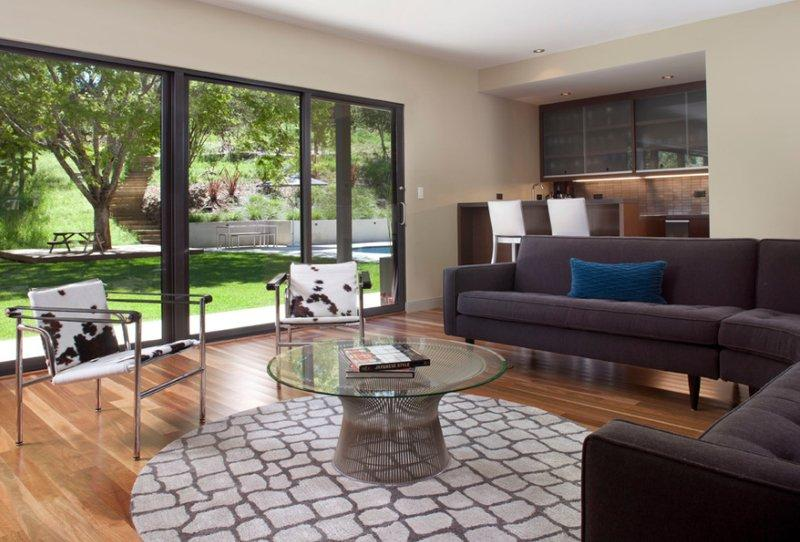

In [1]:
from langchain.vectorstores import Chroma
from langchain_experimental.open_clip import OpenCLIPEmbeddings
from IPython.display import HTML, display
import base64

def is_base64(s):
    """Check if a string is Base64 encoded"""
    try:
        return base64.b64encode(base64.b64decode(s)) == s.encode()
    except Exception:
        return False


def plt_img_base64(img_base64):
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'

    # Display the image by rendering the HTML
    display(HTML(image_html))

# Function to perform MMR search
def search_listings_using_mmr(vectorstore, query, k=4, fetch_k=8,lambda_mmr=0.5 ):
    # Create standard retriever with similarity search
    retriever = vectorstore.as_retriever(
        search_type="mmr",
        search_kwargs={
            "k": k,
            "fetch_k": fetch_k,
            "lambda_mult": lambda_mmr,
        }
    )

    # Perform search
    results = retriever.get_relevant_documents(query)
    return results


vectorstore = Chroma(
    collection_name="real_estate_rag",
    persist_directory="./chroma.db",
    embedding_function=OpenCLIPEmbeddings()
)

# Testing
search_query = "Find luxury homes with modern amenities"
search_results = search_listings_using_mmr(vectorstore, search_query)

# Print search results
for i, doc in enumerate(search_results, 1):
    print(f"\nResult {i}:")
    if is_base64(doc.page_content):
      plt_img_base64(doc.page_content)
    else:
      print(doc.page_content)


#Step 4:Building Buyer Preferences



In [5]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
import json

# questions for buyer preferences
PREFERENCE_QUESTIONS = [
    "How big do you want your house to be?",
    "What are 3 most important things for you in choosing this property?",
    "Which amenities would you like?",
    "Which transportation options are important to you?",
    "How urban do you want your neighborhood to be?"
]

# Example answers
EXAMPLE_ANSWERS = [
    "A spacious five-bedroom house with a large backyard and a finished basement.",
    "Safety, a great view, and nearby entertainment options.",
    "A home office, a patio for outdoor dining, and built-in smart home features.",
    "Easy access to a reliable bus line, proximity to a major highway, and bike-friendly roads.",
    "A balance between suburban tranquility and access to urban amenities like restaurants and theaters."
]


PREFERENCE_PARSER_TEMPLATE = """
You are an expert real estate preference analyzer. Given a set of buyer responses to preference questions,
create a structured analysis that can be used for property matching.

Questions and Answers:
{qa_pairs}

Please analyze these preferences and create a structured JSON output with the following fields:
- size_requirements: Details about desired house size, bedrooms, etc.
- location_preferences: Neighborhood characteristics and location requirements
- must_have_features: List of essential features or deal-breakers
- nice_to_have_features: List of preferred but not essential features
- lifestyle_factors: Environmental and community aspects important to the buyer
- transportation_needs: Transportation and accessibility requirements
- price_sensitivity: Any mentions or implications about budget (if mentioned)

Ensure the output is in valid JSON format and captures both explicit and implicit preferences from the answers.
"""

class PreferenceCollector:
    def __init__(self, openai_api_key):
        self.llm = ChatOpenAI(
            model_name="gpt-3.5-turbo",
            temperature=0.2,
            openai_api_key=openai_api_key
        )

        self.parser_prompt = PromptTemplate(
            input_variables=["qa_pairs"],
            template=PREFERENCE_PARSER_TEMPLATE
        )

        self.chain = LLMChain(
            llm=self.llm,
            prompt=self.parser_prompt
        )

    def collect_preferences(self, interactive=False):
        """Collect buyer preferences either interactively or using example data"""
        if interactive:
            answers = []
            for question in PREFERENCE_QUESTIONS:
                answer = input(f"{question}\nYour answer: ")
                answers.append(answer)
        else:
            answers = EXAMPLE_ANSWERS

        return dict(zip(PREFERENCE_QUESTIONS, answers))

    def format_qa_pairs(self, preferences_dict):
        """Format Q&A pairs for the LLM prompt"""
        qa_pairs = ""
        for question, answer in preferences_dict.items():
            qa_pairs += f"QUESTION: {question}\nANSWER: {answer}\n\n"
        return qa_pairs

    def parse_preferences(self, preferences_dict):
        """Parse raw preferences into structured format using LLM"""
        qa_pairs = self.format_qa_pairs(preferences_dict)

        try:
            # Get structured analysis from LLM
            response = self.chain.run(qa_pairs=qa_pairs)

            # Parse JSON response
            structured_preferences = json.loads(response)
            return structured_preferences

        except json.JSONDecodeError as e:
            print(f"Error parsing LLM response as JSON: {e}")
            return None
        except Exception as e:
            print(f"Error processing preferences: {e}")
            return None

# Initialize preference collector
collector = PreferenceCollector(openai_api_key=openapi_key)

# Collect preferences
raw_preferences = collector.collect_preferences(interactive=False)
# Parse preferences into structured format
structured_preferences = collector.parse_preferences(raw_preferences)

if structured_preferences:
  print("\nStructured Preferences:")
  print(json.dumps(structured_preferences, indent=2))
else:
  print("Failed to process preferences")



Structured Preferences:
{
  "size_requirements": {
    "house_size": "Spacious",
    "bedrooms": 5,
    "backyard": "Large",
    "basement": "Finished"
  },
  "location_preferences": {
    "safety": "High priority",
    "view": "Great view",
    "entertainment": "Nearby options",
    "urban_access": "Balanced suburban and urban amenities"
  },
  "must_have_features": [
    "Safety",
    "Home office",
    "Patio for outdoor dining",
    "Built-in smart home features"
  ],
  "nice_to_have_features": [
    "Nearby entertainment options"
  ],
  "lifestyle_factors": {
    "community": "Desire for nearby entertainment options"
  },
  "transportation_needs": {
    "bus_line": "Easy access to reliable bus line",
    "highway": "Proximity to major highway",
    "bike_friendly": "Bike-friendly roads"
  },
  "price_sensitivity": "Not explicitly mentioned"
}


# Step 5: Searching Based on Preferences

**Rubric:** Semantic Search | Listings Based on Buyer Preferences

In [ ]:
vectorstore = Chroma(
    collection_name="real_estate_rag",
    embedding_function=OpenCLIPEmbeddings()
)


In [9]:
from typing import Dict, List
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
import json

class HomeMatchSearchEngine:
    def __init__(self, vectorstore, openai_api_key):
        self.vectorstore = vectorstore
        self.llm = ChatOpenAI(
            model_name="gpt-3.5-turbo",
            temperature=0.0,
            openai_api_key=openai_api_key
        )

        # Improved search query template
        self.query_template = PromptTemplate(
            input_variables=["preferences"],
            template="""
            Create a detailed property search query based on these preferences:
            {preferences}

            Focus on:
            1. Primary requirements (bedrooms, bathrooms, price range)
            2. Location preferences and neighborhood characteristics
            3. Must-have features and amenities
            4. Lifestyle and environmental factors

            Return only the search query as a detailed but concise paragraph.
            """
        )

        self.chain = LLMChain(llm=self.llm, prompt=self.query_template)

    def semantic_search(self,
                       structured_preferences: Dict,
                       num_results: int = 3,
                       mmr_lambda: float = 0.5) -> List:
        """
        Perform semantic search with MMR

        Args:
            structured_preferences: Dict of buyer preferences
            num_results: Number of results to return
            mmr_lambda: Trade-off between max diversity (0.0) and minimum diveristy (1.0)
        """
        try:
            # Generate search query from preferences
            search_query = self.chain.run(preferences=json.dumps(structured_preferences))

            # Configure MMR retriever
            retriever = self.vectorstore.as_retriever(
                search_type="mmr",
                search_kwargs={
                    "k": num_results,
                    "fetch_k": num_results * 2,  # Fetch more candidates for diversity
                    "lambda_mult": mmr_lambda
                }
            )
            # Perform search
            results = retriever.get_relevant_documents(search_query)

            return results

        except Exception as e:
            print(f"Search error: {e}")
            return []



    def explain_match(self, listing: str, preferences: Dict) -> str:
        """Generate explanation for why listing matches preferences"""
        explanation_prompt = PromptTemplate(
            input_variables=["listing", "preferences"],
            template="""
            Explain why this property matches the buyer's preferences:

            Property Details:
            {listing}

            Buyer Preferences:
            {preferences}

            ACTION: Provide a concise explanation focusing on the key matching points
            """
        )

        chain = LLMChain(llm=self.llm, prompt=explanation_prompt)
        return chain.run(
            listing=json.dumps(listing),
            preferences=json.dumps(preferences)
        )

# Initialize search engine
search_engine = HomeMatchSearchEngine(vectorstore, openai_api_key=openapi_key)

# Perform semantic search
results = search_engine.semantic_search(
        structured_preferences=structured_preferences,
        num_results=5,
        mmr_lambda=0.5
    )
for doc in results:
  if is_base64(doc.page_content):
    plt_img_base64(doc.page_content)
  else:
    print(doc.page_content)
  print("\n")
  print("The Why of this match: ")
  print(search_engine.explain_match(doc.page_content, structured_preferences))

  print("-" * 80)



Luxurious modern home in the heart of Beverly Hills. This stunning property features sleek design, high-end finishes, and a spacious open floor plan.


The Why of this match: 
This property matches the buyer's preferences as it meets their size requirements with a spacious open floor plan and five bedrooms. It also features high-end finishes and a sleek design, aligning with their desire for a luxurious home. Additionally, the location in Beverly Hills offers nearby entertainment options and a balanced mix of suburban and urban amenities, fulfilling their lifestyle factors.
--------------------------------------------------------------------------------
Elegant Mediterranean villa in exclusive Pacific Palisades. This spacious home boasts panoramic ocean views, a gourmet kitchen, and a luxurious master suite.


The Why of this match: 
This property matches the buyer's preferences because it meets their size requirements with a spacious layout and 5 bedrooms. It also offers a large backy

# Step 6: Augmented Response Generation and Personalize Listing

**Rubric:** LLM Augmentation: For each retrieved listing, use the LLM to augment the description, tailoring it to resonate with the buyer’s specific preferences. This involves subtly emphasizing aspects of the property that align with what the buyer is looking for.

In [11]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from typing import Dict, List
import json

class ListingPersonalizer:
    def __init__(self, openai_api_key):
        self.llm = ChatOpenAI(
            model_name="gpt-3.5-turbo",
            temperature=0.3,  # Lower temperature for more factual outputs
            openai_api_key=openai_api_key
        )

        # Prompt for personalizing descriptions
        self.personalization_template = PromptTemplate(
            input_variables=["listing", "preferences"],
            template="""
            You are an expert real estate agent personalizing a property listing.

            ORIGINAL LISTING:
            {listing}

            BUYER PREFERENCES:
            {preferences}

            TASK:
            Rewrite the listing description to highlight features that match the buyer's preferences.

            REQUIREMENTS:
            1. Maintain absolute factual accuracy - DO NOT ADD or remove any property features
            2. Preserve all numerical data (price, size, rooms, etc.)
            3. Emphasize aspects that align with buyer preferences
            4. Add contextual details about how features meet the buyer's needs
            5. Keep the tone professional and authentic

            Return the response in this JSON format:
            {{
                "personalized_description": "The enhanced property description",
                "highlighted_features": ["3-5 key features that match preferences"],
                "lifestyle_match": "Brief statement about property-lifestyle fit",
                "original_specs": {{
                    "price": "original price",
                    "bedrooms": "original bedroom count",
                    "bathrooms": "original bathroom count",
                    "size": "original size",
                    "location": "original location"
                }}
            }}
            """
        )

        self.chain = LLMChain(
            llm=self.llm,
            prompt=self.personalization_template
        )

    def personalize_listing(self, listing: str, buyer_preferences: Dict) -> Dict:
        """
        Create a personalized version of the listing based on buyer preferences
        while maintaining factual integrity.
        """
        try:

            # Generate personalized content
            response = self.chain.run(
                listing=listing,
                preferences=json.dumps(buyer_preferences)
            )

            # Parse the response
            personalized = json.loads(response)


            return personalized

        except Exception as e:
            print(f"Error personalizing listing: {e}")
            return listing

    def verify_facts(self, personalized_specs: Dict, original_listing: str) -> bool:
        """
        Verify that no factual information has been altered
        """
        key_facts = ['price', 'bedrooms', 'bathrooms', 'size']
        for fact in key_facts:
            orig_value = str(original_listing.get(fact, '')).lower()
            pers_value = str(personalized_specs.get(fact, '')).lower()
            if orig_value and pers_value and orig_value != pers_value:
                raise ValueError(f"Factual discrepancy found in {fact}")
        return True




# Initialize personalizer
personalizer = ListingPersonalizer(openapi_key)


augmented_response=[]
# Generate personalized listing
for doc in results:
    augmentation = personalizer.personalize_listing(
       doc.page_content,
       structured_preferences
    )
    augmented_response.append(augmentation)
    print("Original Listing:")
    print(doc.page_content)
    print("\n")

    print("Augmented Listing:")
    print(augmentation)
    print("-" * 80)





Original Listing:
Luxurious modern home in the heart of Beverly Hills. This stunning property features sleek design, high-end finishes, and a spacious open floor plan.


Augmented Listing:
{'personalized_description': 'Experience luxury living in this spacious modern home located in the prestigious Beverly Hills area. This stunning property boasts high-end finishes and a sleek design that will impress even the most discerning buyer. With 5 bedrooms, a large backyard, and a finished basement, this home offers the perfect blend of style and functionality.', 'highlighted_features': ['Spacious 5 bedrooms', 'Large backyard for outdoor activities', 'Finished basement for additional living space', 'High-end finishes and sleek design', 'Built-in smart home features for added convenience'], 'lifestyle_match': 'This property is ideal for those who prioritize safety, enjoy great views, and seek nearby entertainment options. The balanced suburban and urban amenities provide the perfect mix for a v

# Step 7: Check Factual Integrity
**Rubric**:Maintaining Factual Integrity: Ensure that the augmentation process enhances the appeal of the listing without altering factual information.

In [12]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from typing import Dict, Tuple
import json

class FactualIntegrityChecker:
    def __init__(self, openai_api_key):
        self.llm = ChatOpenAI(
            model_name="gpt-3.5-turbo",
            temperature=0.0,  # Zero temperature for maximum consistency
            openai_api_key=openai_api_key
        )

        # Prompt for fact checking
        self.fact_check_template = PromptTemplate(
            input_variables=["original", "personalized"],
            template="""
            You are a precise fact-checking system for real estate listings. Compare the original listing with its personalized version.

            ORIGINAL LISTING:
            {original}

            PERSONALIZED LISTING:
            {personalized}

            TASK:
            1. Compare all factual information between the listings
            2. Check for any discrepancies or alterations in:
               - Price
               - Number of bedrooms/bathrooms
               - Square footage
               - Location/neighborhood
               - Property features and amenities
               - Year built (if mentioned)
               - Property type
               - Any other numerical or factual data

            Return the analysis in this JSON format:
            {{
                "factual_accuracy_score": <score between 0-100>,
                "discrepancies": [
                    {{
                        "field": "field_name",
                        "original": "original_value",
                        "personalized": "personalized_value",
                        "severity": "high/medium/low"
                    }}
                ],
                "verified_facts": [
                    "list of correctly maintained facts"
                ],
                "overall_assessment": "brief assessment of factual integrity",
                "is_acceptable": true/false
            }}
            IF severity is LOW then this is accepta
            """
        )

        self.chain = LLMChain(
            llm=self.llm,
            prompt=self.fact_check_template
        )

    def verify_listing(self, original_listing: str, personalized_listing: Dict) -> Tuple[bool, Dict]:
        """
        Verify factual integrity between original and personalized listings
        Returns: (is_acceptable, detailed_analysis)
        """
        try:

            personalized_str = (json.dumps(personalized_listing)
                              if isinstance(personalized_listing, dict)
                              else personalized_listing)

            # Run factual Integrity
            analysis_str = self.chain.run(
                original=original_listing,
                personalized=personalized_str
            )

            analysis = json.loads(analysis_str)

            # Determine if acceptable ( score >= 95 and no high-severity discrepancies)
            is_acceptable = (
                analysis['factual_accuracy_score'] >= 85 and
                not any(d['severity'] == 'high' for d in analysis['discrepancies'])
            )

            return is_acceptable, analysis

        except Exception as e:
            print(f"Error during fact verification: {e}")
            return False, {
                "error": str(e),
                "factual_accuracy_score": 0,
                "discrepancies": [],
                "is_acceptable": False
            }


factual_checker = FactualIntegrityChecker(openapi_key)
for i,doc in enumerate(results):
    is_acceptable, analysis = factual_checker.verify_listing(
       doc.page_content,
       augmented_response[i]
    )
    if not is_acceptable:
        print("Warning: Factual discrepancies detected!")
        print(analysis)
    else:
        print(f"Personalization is acceptable {augmented_response[i]} ")
    print("-" * 80)



{'factual_accuracy_score': 85, 'discrepancies': [{'field': 'Price', 'original': 'original price', 'personalized': 'Not mentioned', 'severity': 'medium'}, {'field': 'Number of bedrooms', 'original': '5', 'personalized': '5', 'severity': 'low'}, {'field': 'Number of bathrooms', 'original': 'original bathroom count', 'personalized': 'Not mentioned', 'severity': 'medium'}, {'field': 'Square footage', 'original': 'original size', 'personalized': 'Not mentioned', 'severity': 'medium'}, {'field': 'Location/neighborhood', 'original': 'Beverly Hills', 'personalized': 'Beverly Hills', 'severity': 'low'}, {'field': 'Property features and amenities', 'original': 'High-end finishes, sleek design', 'personalized': 'High-end finishes, sleek design, 5 bedrooms, large backyard, finished basement, built-in smart home features', 'severity': 'high'}], 'verified_facts': ['Number of bedrooms: 5', 'Location: Beverly Hills'], 'overall_assessment': 'Most factual information is accurate, but there are discrepan